# Part I

[A]

Let us assume we have a policy (𝝅 : S → A ) that assigns an action to each state. Action 𝝅(s) will be chosen each time the system is at state s.

Policy Iteration is a method used in reinforcement learning and Markov Decision Processes (MDPs) to find an optimal policy, which specifies the best action to take in each state to maximize the expected cumulative reward over time. The process involves two main steps: Policy Evaluation and Policy Improvement.


**Step 1: Initialization**

We start with a random policy


 **Step 2: Policy Evaluation**

In this step, we compute the value function $V^\pi(s)$ for the current policy $\pi$. This involves solving the following system of linear equations derived from the Bellman expectation equation for policy $\pi$:

$$ V^\pi(s) = R(s, \pi(s)) + \gamma \sum_{s'} P(s'|s, \pi(s)) V^\pi(s') $$

**Step 3: Policy Improvement**

In this step, we improve the policy based on the current value function $V^\pi(s)$. We update the policy $\pi$ to $\pi'$ by choosing the action that maximizes the expected value in each state:

$$ \pi'(s) = \arg\max_a \left[ R(s, a) + \gamma \sum_{s'} P(s'|s, a) V^\pi(s') \right] $$

For each state, calculate the action-value function $Q(s, a)$ and select the action that maximizes $Q(s, a)$:

**Step 4: Convergence Check**

Check if the policy has changed. If $\pi' = \pi$, the policy is optimal and we stop. Otherwise, set $\pi = \pi'$ and repeat from Step 2.


Repeat Policy Evaluation and Policy Improvement until the policy no longer changes. After a few iterations, we will converge to the optimal policy.

After convergence, we obtain the optimal policy $\pi^*$ and the corresponding value function $V^*$.

In [ ]:
from IPython.display import Image

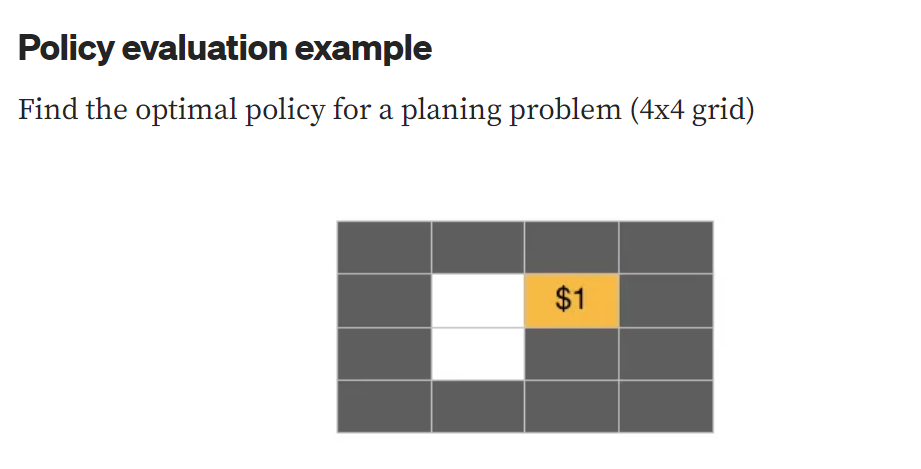

In [ ]:
Image(filename='/content/policy iteration/1.png', width = 800)

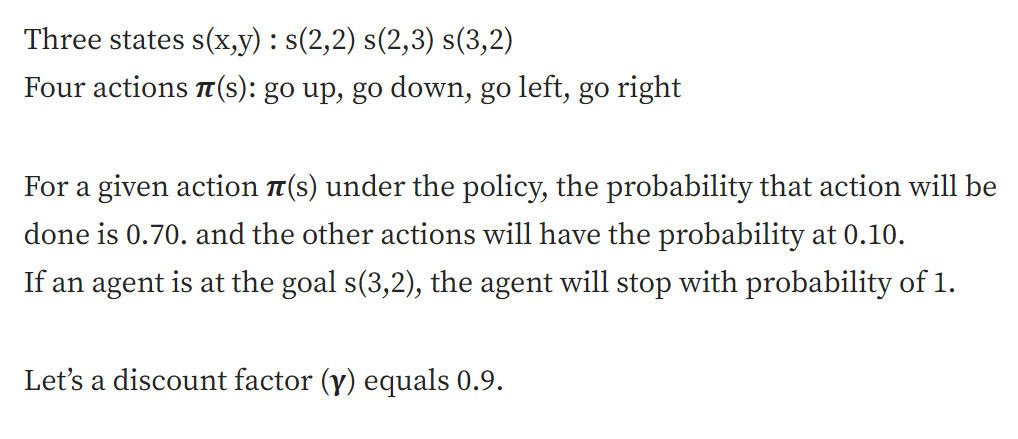

In [ ]:
Image(filename='/content/policy iteration/2.png', width = 800)

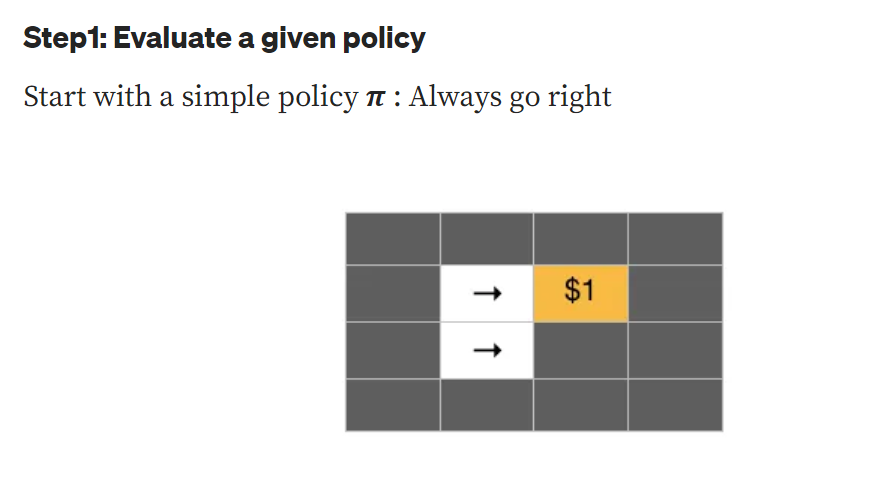

In [ ]:
Image(filename='/content/policy iteration/3.png', width = 800)

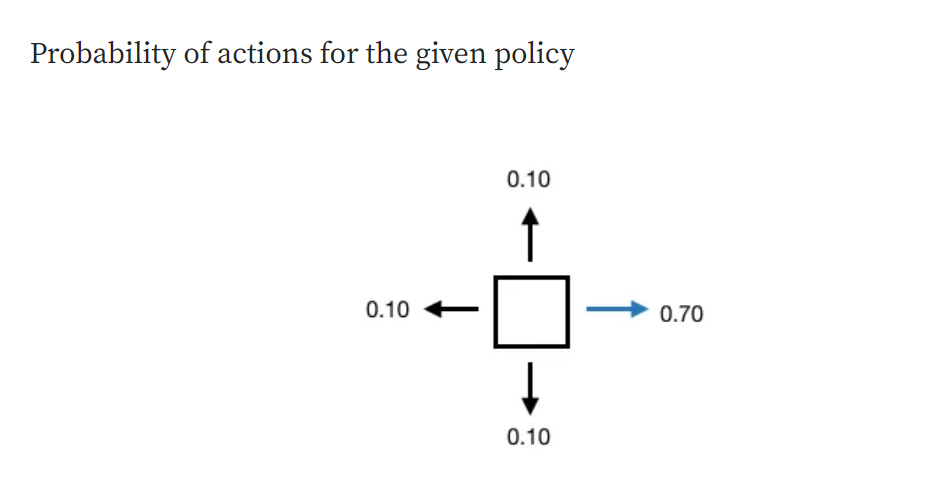

In [ ]:
Image(filename='/content/policy iteration/4.png', width = 800)

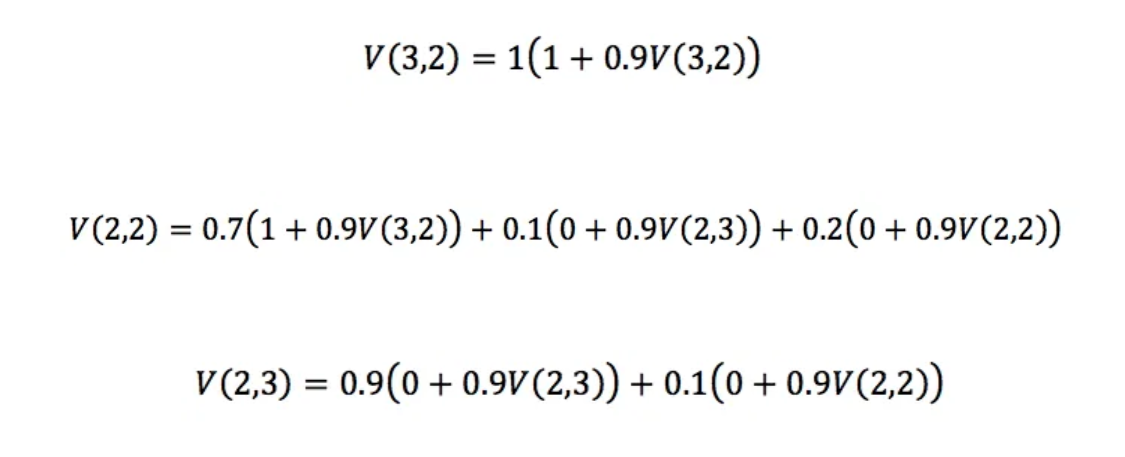

In [ ]:
Image(filename='/content/policy iteration/5.png', width = 800)

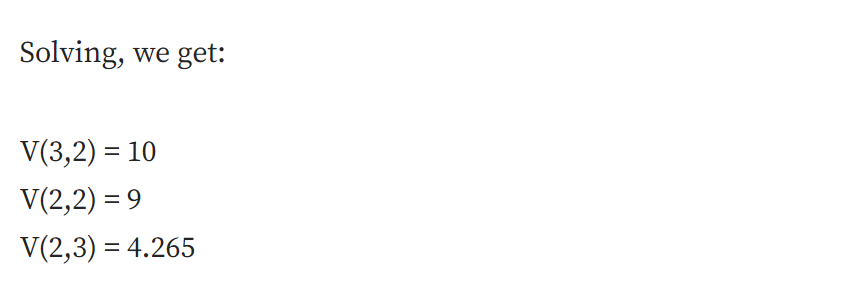

In [ ]:
Image(filename='/content/policy iteration/6.png', width = 800)

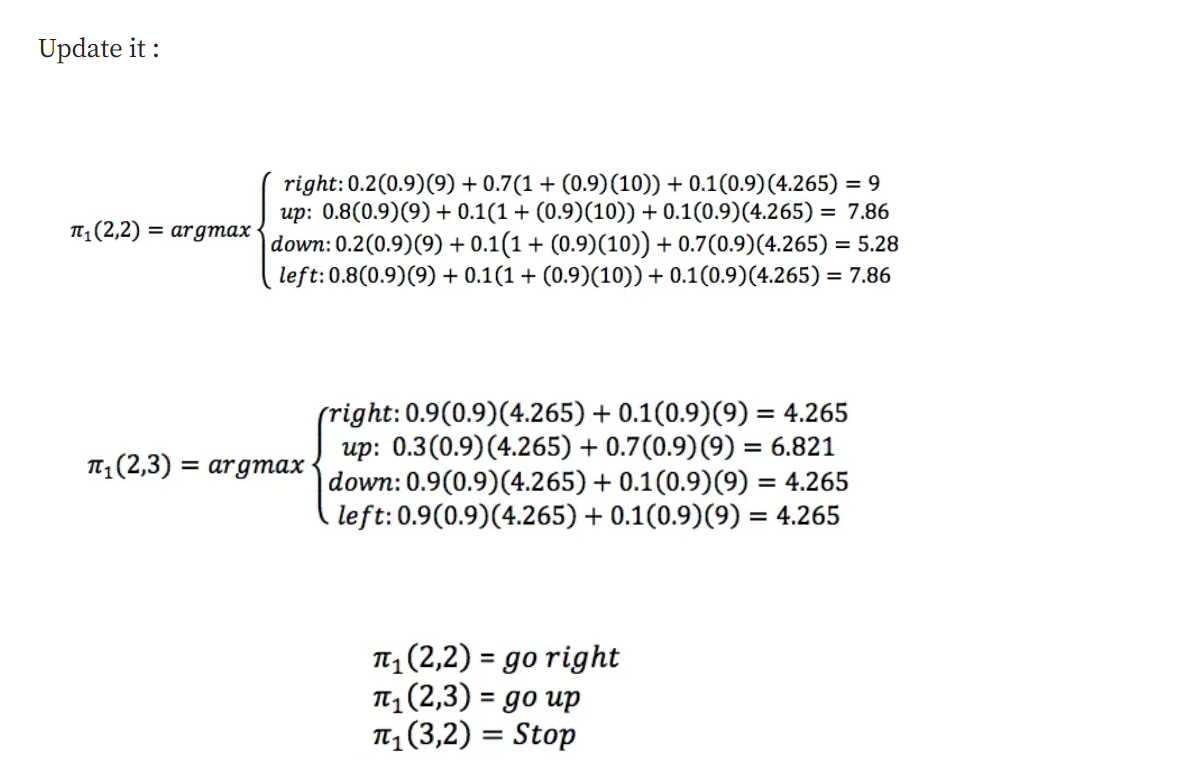

In [ ]:
Image(filename='/content/policy iteration/7.png', width = 800)

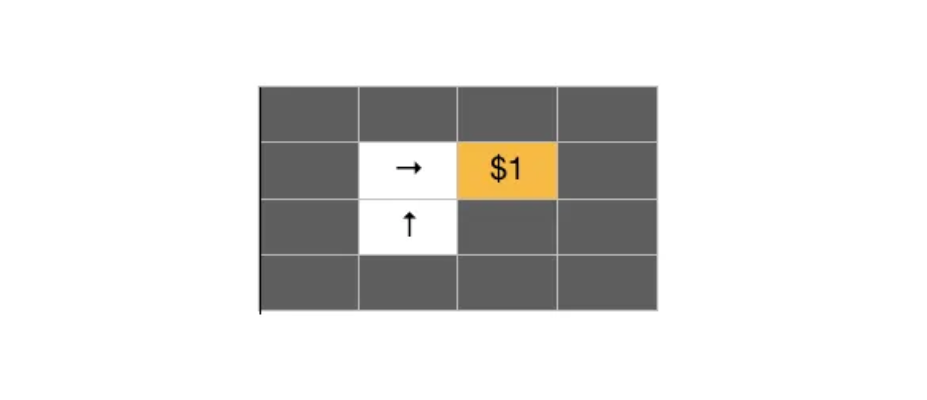

In [ ]:
Image(filename='/content/policy iteration/8.png', width = 800)

**[B]**

Grid search is done in this part. (Because of GPU limit I have decreased the number of epochs, increased the batch-size and also defined a small search space.)

In [ ]:
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import itertools
import os

# Initialize the CartPole environment
env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
output_dir = 'model_output/cartpole'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate, gamma, epsilon, epsilon_decay, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, activation='relu', input_dim=self.state_size))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * np.amax(t)
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

def evaluate_agent(agent, n_episodes=20):
    scores = []
    for e in range(n_episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        done = False
        time = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            time += 1
            if done:
                scores.append(time)
                break
        if len(agent.memory) > agent.batch_size:
            agent.train()
    return np.mean(scores)

# Define the hyperparameters to search
learning_rates = [0.001, 0.005, 0.01]
gammas = [0.9, 0.95, 0.99]

best_score = -float('inf')
best_params = None

# Perform grid search
for lr, gamma in itertools.product(learning_rates, gammas):
    print(f'Testing with lr={lr}, gamma={gamma}')
    agent = DQNAgent(state_size, action_size, lr, gamma, epsilon=1.0, epsilon_decay=0.995, batch_size=32)
    score = evaluate_agent(agent, n_episodes=20)
    print(f'Score: {score}')
    if score > best_score:
        best_score = score
        best_params = (lr, gamma)

print('Best hyperparameters: ', best_params)

# Train the final model with the best hyperparameters
best_lr, best_gamma = best_params

agent = DQNAgent(
    state_size,
    action_size,
    best_lr,
    best_gamma,
    epsilon=1.0,
    epsilon_decay=0.995,
    batch_size=32
)

n_episodes = 30
for e in range(n_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    done = False
    time = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        time += 1
        if done:
            print("episode: {}/{}, score: {}, e: {:.2f}".format(e, n_episodes-1, time, agent.epsilon))
            break
    if len(agent.memory) > agent.batch_size:
        agent.train()
    if e % 10 == 0:
        agent.update_target_model()
    if e % 20 == 0:
        agent.save(output_dir + "weights_" + '{:04d}'.format(e) + ".hdf5")

def test_agent(agent, env, n_episodes=10):
    for e in range(n_episodes):
        state = env.reset()
        state = np.reshape(state, [1, agent.state_size])
        done = False
        time = 0
        while not done:
            action = np.argmax(agent.model.predict(state)[0])
            next_state, reward, done, _ = env.step(action)
            state = np.reshape(next_state, [1, agent.state_size])
            time += 1
            if done:
                print(f"Test Episode: {e+1}/{n_episodes}, Score: {time}")
                break
            env.render()

test_agent(agent, env)


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Testing with lr=0.001, gamma=0.9


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
Score: 19.1
Testing with lr=0.01, gamma=0.95
1/1 [==============================] - 0s 23ms/step
Score: 21.55
Testing with lr=0.01, gamma=0.99
1/1 [==============================] - 0s 21ms/step
Score: 23.2
Best hyperparameters:  (0.005, 0.9)
episode: 0/29, score: 12, e: 1.00
episode: 1/29, score: 13, e: 1.00
episode: 2/29, score: 17, e: 1.00
1/1 [==============================] - 0s 22ms/step
episode: 3/29, score: 32, e: 0.99
1/1 [==============================] - 0s 35ms/step
episode: 4/29, score: 19, e: 0.99
1/1 [==============================] - 0s 17ms/step
episode: 5/29, score: 34, e: 0.99
1/1 [==============================] - 0s 21ms/step
episode: 6/29, score: 26, e: 0.98
1/1 [==============================] - 0s 25ms/step
episode: 7/29, score: 67, e: 0.98
1/1 [==============================] - 0s 17ms/step
episode: 8/29, score: 27, e: 0.97
1/1 [==============================]

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 22ms/step
Test Episode: 1/10, Score: 12
1/1 [==============================] - 0s 30ms/step
Test Episode: 2/10, Score: 13
1/1 [==============================] - 0s 16ms/step
Test Episode: 3/10, Score: 12
1/1 [==============================] - 0s 16ms/step
Test Episode: 4/10, Score: 12
1/1 [==============================] - 0s 24ms/step
Test Episode: 5/10, Score: 12
1/1 [==============================] - 0s 16ms/step
Test Episode: 6/10, Score: 13
1/1 [==============================] - 0s 16ms/step
Test Episode: 7/10, Score: 12
1/1 [==============================] - 0s 22ms/step
Test Episode: 8/10, Score: 11
1/1 [==============================] - 0s 17ms/step
Test Episode: 9/10, Score: 12
1/1 [==============================] - 0s 15ms/step
Test Episode: 10/10, Score: 10


[C]

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
episode: 122/200, score: 13, e: 0.56
1/1 [==============================] - 0s 51ms/step
episode: 123/200, score: 29, e: 0.56
1/1 [==============================] - 0s 18ms/step
episode: 124/200, score: 3, e: 0.56
1/1 [==============================] - 0s 26ms/step
episode: 125/200, score: 7, e: 0.56
1/1 [==============================] - 0s 47ms/step
episode: 126/200, score: 4, e: 0.55
1/1 [==============================] - 0s 26ms/step
episode: 127/200, score: 9, e: 0.55
1/1 [==============================] - 0s 41ms/step
episode: 128/200, score: 15, e: 0.55
1/1 [==============================] - 0s 27ms/step
episode: 129/200, score: 14, e: 0.55
1/1 [==============================] - 0s 26ms/step
episode: 130/200, score: 6, e: 0.54
1/1 [==============================] - 0s 29ms/step
episode: 131/200, score: 3, e: 0.54
1/1 [==============================] - 0s 25ms/step
episode: 132/

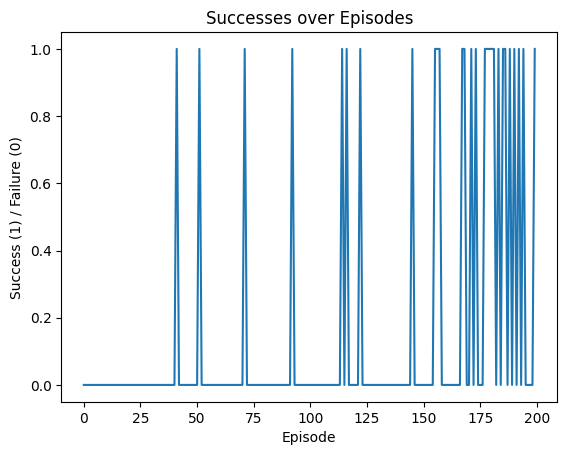

In [ ]:
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Nadam
import os
import matplotlib.pyplot as plt

# Initialize the FrozenLake-v1 environment
env = gym.make('FrozenLake-v1', is_slippery=False)

state_size = env.observation_space.n
action_size = env.action_space.n
batch_size = 32
n_episodes = 200
output_dir = 'model_output/frozenlake/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Nadam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

def one_hot_encode(state, state_size):
    state_encoded = np.zeros(state_size)
    state_encoded[state] = 1
    return np.reshape(state_encoded, [1, state_size])

agent = DQNAgent(state_size, action_size)

# Track success per episode
successes = []

for e in range(n_episodes):
    state = env.reset()
    state = one_hot_encode(state, state_size)

    done = False
    time = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = one_hot_encode(next_state, state_size)
        if done:
            if next_state[0][state_size - 1] == 1:  # reached the goal
                reward = 1  # success
                successes.append(1)
            else:
                reward = 0  # failure
                successes.append(0)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        time += 1

        if done:
            print(f"episode: {e}/{n_episodes}, score: {time}, e: {agent.epsilon:.2}")

    if len(agent.memory) > batch_size:
        agent.train(batch_size)

    if e % 50 == 0:
        agent.save(output_dir + f"weights_{e:04d}.hdf5")

# Plotting the results
plt.plot(successes)
plt.xlabel('Episode')
plt.ylabel('Success (1) / Failure (0)')
plt.title('Successes over Episodes')
plt.show()


In [ ]:
# Track success per episode during testing
test_successes = []
test_episodes = 40  # Number of episodes for testing

# Set epsilon to 0 for testing
agent.epsilon = 0

for e in range(test_episodes):
    state = env.reset()
    state = one_hot_encode(state, state_size)

    done = False
    time = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = one_hot_encode(next_state, state_size)
        if done:
            if next_state[0][state_size - 1] == 1:  # reached the goal
                reward = 1  # success
                test_successes.append(1)
            else:
                reward = 0  # failure
                test_successes.append(0)
        state = next_state
        time += 1

        if done:
            print(f"Test episode: {e}/{test_episodes}, score: {time}")

# Calculate success rate during testing
test_success_rate = (sum(test_successes) / test_episodes) * 100
print("Test Success Rate:", test_success_rate, "%")


1/1 [==============================] - 0s 20ms/step
Test episode: 0/40, score: 6
1/1 [==============================] - 0s 20ms/step
Test episode: 1/40, score: 6
1/1 [==============================] - 0s 19ms/step
Test episode: 2/40, score: 6
1/1 [==============================] - 0s 18ms/step
Test episode: 3/40, score: 6
1/1 [==============================] - 0s 19ms/step
Test episode: 4/40, score: 6
1/1 [==============================] - 0s 18ms/step
Test episode: 5/40, score: 6
1/1 [==============================] - 0s 19ms/step
Test episode: 6/40, score: 6
1/1 [==============================] - 0s 18ms/step
Test episode: 7/40, score: 6
1/1 [==============================] - 0s 18ms/step
Test episode: 8/40, score: 6
1/1 [==============================] - 0s 22ms/step
Test episode: 9/40, score: 6
1/1 [==============================] - 0s 18ms/step
Test episode: 10/40, score: 6
1/1 [==============================] - 0s 18ms/step
Test episode: 11/40, score: 6
1/1 [=====================

# Part II

**[A]**

### Recurrent Neural Networks (RNNs)
Recurrent Neural Networks (RNNs) are a type of neural network designed for sequence data. Unlike traditional feedforward neural networks, RNNs have connections that form cycles, allowing information to persist. This makes them particularly suited for tasks where the context of previous inputs is important, such as time series prediction, language modeling, and speech recognition.

 RNNs process input sequences one element at a time, maintaining a hidden state that captures information about previous elements.

 At each time step $ t $, the hidden state $ h_t $ is updated based on the current input $ x_t $ and the previous hidden state $ h_{t-1} $.
- **Formulation**:
  $$
  h_t = \sigma(W_h h_{t-1} + W_x x_t + b)
  $$

  where $ W_h $ and $ W_x $ are weight matrices, $ b $ is a bias vector, and $ \sigma $ is an activation function (typically tanh or ReLU).



### Problems with Vanilla RNNs
1. **Vanishing Gradient Problem**: During backpropagation, gradients can become very small, causing earlier layers to learn very slowly or not at all. This makes it difficult for RNNs to capture long-term dependencies.


2. **Exploding Gradient Problem**: Conversely, gradients can also become very large, leading to unstable updates and divergence during training.


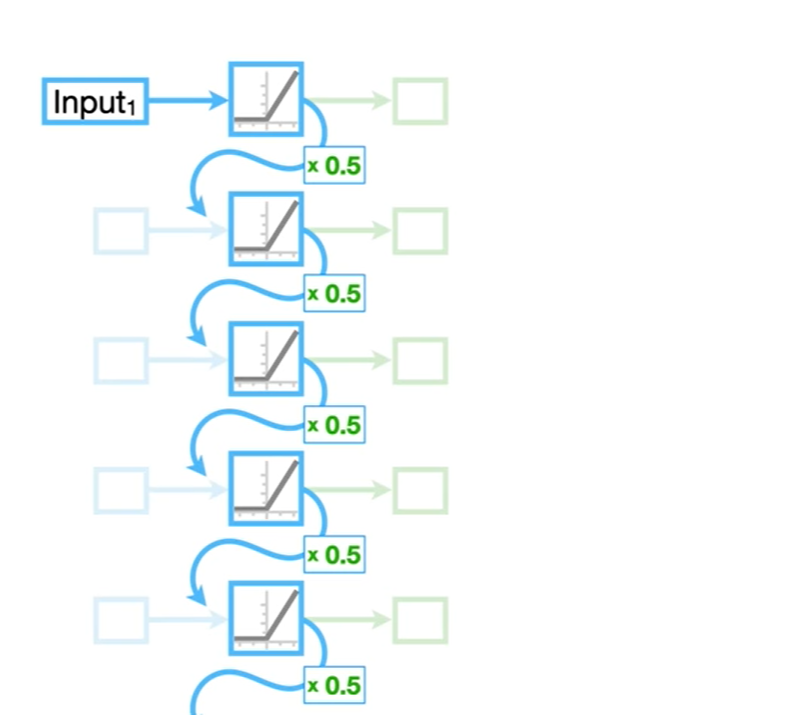

In [ ]:
from IPython.display import Image
Image(filename='/content/part-II/2.png')

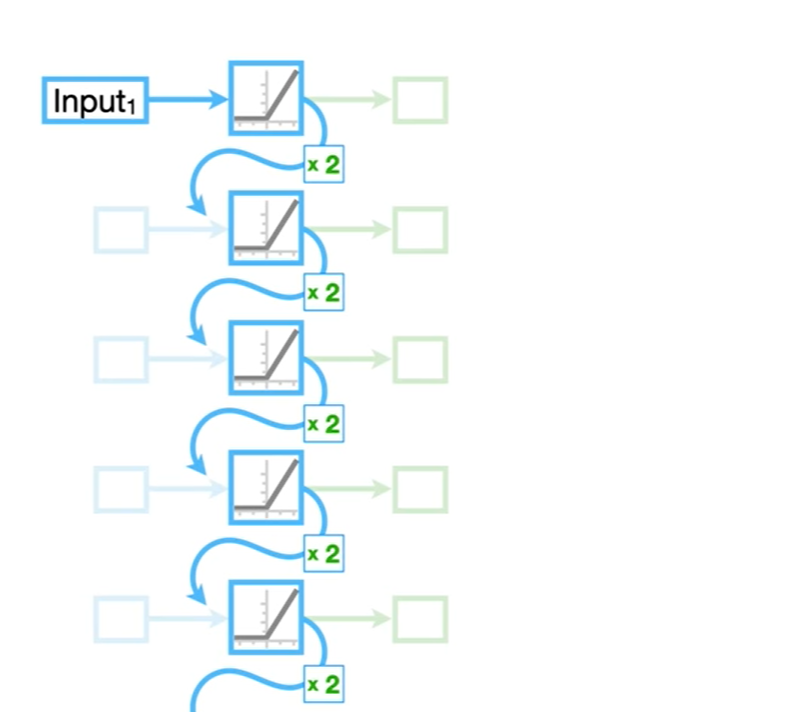

In [ ]:
Image(filename='/content/part-II/1.png')

### Introduction of LSTM (Long Short-Term Memory)
LSTMs were introduced to address the limitations of vanilla RNNs, particularly the vanishing and exploding gradient problems. LSTMs can effectively capture long-term dependencies and maintain information over extended sequences.

### How LSTMs Work
LSTMs introduce a more complex architecture with three types of gates that control the flow of information:

1. **Forget Gate**:
   - Decides what information to discard from the cell state.

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$
2. **Input Gate**:
   - Decides which new information to store in the cell state.

     $$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
   - New candidate values for the cell state:
   
   $$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$
3. **Output Gate**:
   - Decides what part of the cell state to output.:
     $$
     o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
     $$

4. **Cell State Update**:
   - The cell state is updated based on the forget and input gates:
     $$
     C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
     $$

5. **Hidden State Update**:
   - The hidden state is updated based on the output gate and the new cell state:
     $$
     h_t = o_t * \tanh(C_t)
     $$

### Why LSTMs are Effective
- **Gated Mechanisms**: The gates in LSTMs allow the network to retain relevant information for long periods and discard irrelevant information, solving the vanishing gradient problem.
- **Long-Term Dependencies**: LSTMs can maintain and utilize information over long sequences, making them suitable for tasks that require understanding context over extended periods.


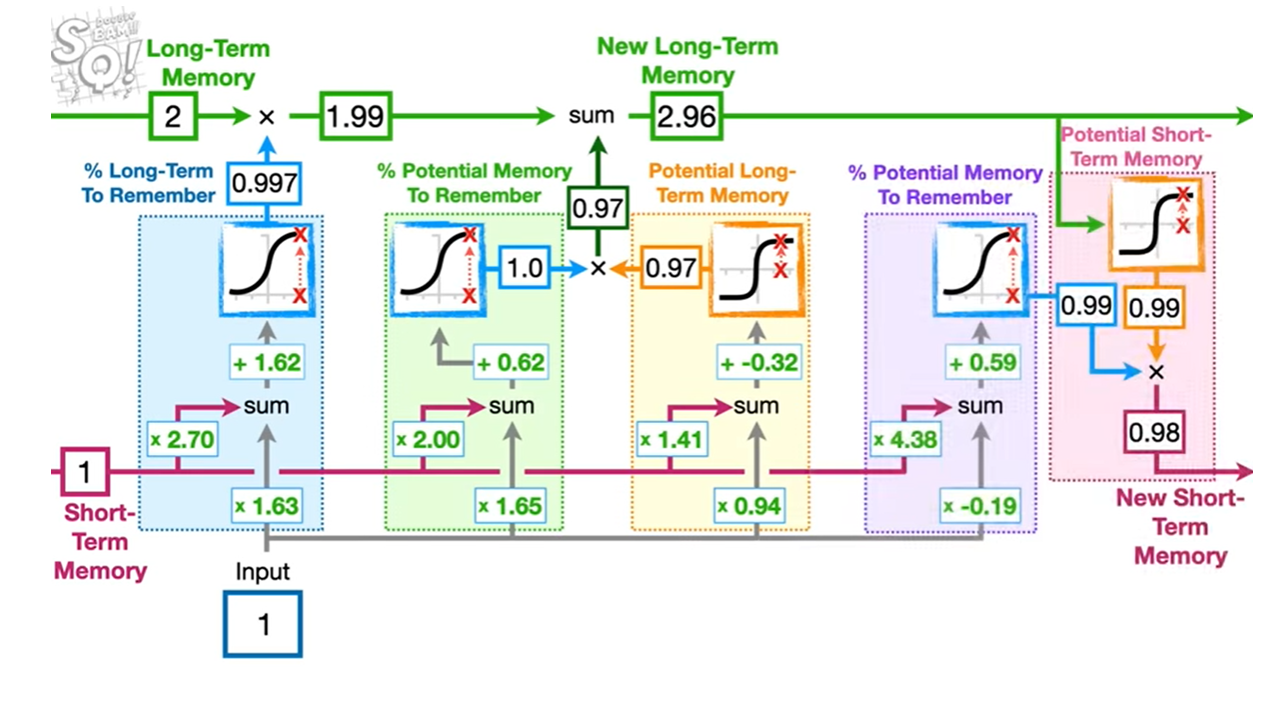

In [ ]:
Image(filename='/content/part-II/3.png', height="600", width = "900")

From left to right, the blocks represent the following gates:
1. Forget Gate
2. Input Gate
3. Cell State Update
4. Output Gate

### Forget Gate:
$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

$$
f_t = \sigma((2.70*0) + (1.63*1) + 1.62)
$$

$$
f_t = \sigma(3.25)
$$


$$
f_t = \frac{1}{1 + e^{-3.25}} \approx 0.997
$$

### Input Gate:
$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$

$$
i_t = \sigma((2.00 * 0) + (1.65 * 1) + 0.62)
$$

$$
i_t = \sigma(2.27)
$$
$$
i_t = \frac{1}{1 + e^{-2.27}} \approx 1.0
$$

### Cell State Update:
$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

$$
\tilde{C}_t = \tanh((1.41 * 0) + (0.94 * 1) + (-0.32))
$$

$$
\tilde{C}_t = \tanh(0.62)
$$

$$
\tilde{C}_t \approx 0.97
$$

### New Cell State:
$$
C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
$$

$$
C_t = (0.997 * 0) + 1.0 * 0.97
$$

$$
C_t \approx 2.96
$$

### Output Gate:
$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$

$$
o_t = \sigma((4.38 * 0) + ((-0.19) * 1) + 0.59)
$$

$$
o_t = \sigma(0 - 0.19 + 0.59)
$$

$$
o_t = \sigma(0.40)
$$

$$
o_t = \frac{1}{1 + e^{-0.40}} \approx 0.99
$$

### New Hidden State:
$$
h_t = o_t * \tanh(C_t)
$$

$$
h_t = 0.99 * \tanh(2.96)
$$

$$
h_t \approx 0.99 * 0.99
$$

$$
h_t \approx 0.98
$$

Given our example with specific weights, we'll calculate the gradients using backpropagation.

Let the gradient pass down by the above cell be:
$$ \delta_{h_t} = \frac{dE}{d{h_t}} $$



If we are using MSE (mean square error) for error, then:
$$ \delta_{h_t} = (y - h(x)) $$


Here \( y \) is the original value and \( h(x) \) is the predicted value.

**Gradient with respect to Output Gate**

$$ \frac{dE}{d{o_t}} = \delta_{h_t} \cdot \frac{\partial{h_t}}{\partial{o_t}} $$


$$ \frac{dE}{d{o_t}} = \delta_{h_t} \cdot \tanh(C_t) $$

In our example it would be:
$$ \frac{dE}{d{o_t}} = \delta_{h_t} \cdot 0.99 $$



**Gradient with respect to Cell State**

$$ \frac{dE}{d{C_t}} = \delta_{h_t} \cdot \frac{\partial{h_t}}{\partial{C_t}} $$


$$ \frac{dE}{d{C_t}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) $$



 **Gradient with respect to Input Gate $ \frac{dE}{d{i_t}} $, $ \frac{dE}{d{g_t}} $**

$$ \frac{dE}{d{i_t}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot \tilde{C_t} $$


$$ \frac{dE}{d{g_t}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot i_t $$



**Gradient with respect to Forget Gate**

$$ \frac{dE}{d{f_t}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot C_{t-1} $$



**Gradient with respect to $ C_{t-1} $**

$$ \frac{dE}{d{C_{t-1}}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot f_t $$



**Gradient with respect to Output Gate Weights**

$$ \frac{dE}{d{W_{xo}}} = \frac{dE}{d{o_t}} \cdot \frac{\partial{o_t}}{\partial{W_{xo}}} $$


$$ \frac{dE}{d{W_{xo}}} = \delta_{h_t} \cdot \tanh(C_t) \cdot \sigma(o_t) \cdot (1 - \sigma(o_t)) \cdot x_t $$



$$ \frac{dE}{d{W_{ho}}} = \frac{dE}{d{o_t}} \cdot \frac{\partial{o_t}}{\partial{W_{ho}}} $$


$$ \frac{dE}{d{W_{ho}}} = \delta_{h_t} \cdot \tanh(C_t) \cdot \sigma(o_t) \cdot (1 - \sigma(o_t)) \cdot h_{t-1} $$



$$ \frac{dE}{d{b_o}} = \frac{dE}{d{o_t}} \cdot \frac{\partial{o_t}}{\partial{b_o}} $$


$$ \frac{dE}{d{b_o}} = \delta_{h_t} \cdot \tanh(C_t) \cdot \sigma(o_t) \cdot (1 - \sigma(o_t)) $$



 **Gradient with respect to Forget Gate Weights**

$$ \frac{dE}{d{W_{xf}}} = \frac{dE}{d{f_t}} \cdot \frac{\partial{f_t}}{\partial{W_{xf}}} $$


$$ \frac{dE}{d{W_{xf}}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot C_{t-1} \cdot \sigma(f_t) \cdot (1 - \sigma(f_t)) \cdot x_t $$



$$ \frac{dE}{d{W_{hf}}} = \frac{dE}{d{f_t}} \cdot \frac{\partial{f_t}}{\partial{W_{hf}}} $$


$$ \frac{dE}{d{W_{hf}}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot C_{t-1} \cdot \sigma(f_t) \cdot (1 - \sigma(f_t)) \cdot h_{t-1} $$



$$ \frac{dE}{d{b_f}} = \frac{dE}{d{f_t}} \cdot \frac{\partial{f_t}}{\partial{b_f}} $$


$$ \frac{dE}{d{b_f}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot C_{t-1} \cdot \sigma(f_t) \cdot (1 - \sigma(f_t)) $$



 **Gradient with respect to Input Gate Weights**

$$ \frac{dE}{d{W_{xi}}} = \frac{dE}{d{i_t}} \cdot \frac{\partial{i_t}}{\partial{W_{xi}}} $$


$$ \frac{dE}{d{W_{xi}}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot \tilde{C_t} \cdot \sigma(i_t) \cdot (1 - \sigma(i_t)) \cdot x_t $$



$$ \frac{dE}{d{W_{hi}}} = \frac{dE}{d{i_t}} \cdot \frac{\partial{i_t}}{\partial{W_{hi}}} $$


$$ \frac{dE}{d{W_{hi}}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot \tilde{C_t} \cdot \sigma(i_t) \cdot (1 - \sigma(i_t)) \cdot h_{t-1} $$



$$ \frac{dE}{d{b_i}} = \frac{dE}{d{i_t}} \cdot \frac{\partial{i_t}}{\partial{b_i}} $$


$$ \frac{dE}{d{b_i}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot \tilde{C_t} \cdot \sigma(i_t) \cdot (1 - \sigma(i_t)) $$



$$ \frac{dE}{d{W_{xg}}} = \frac{dE}{d{g_t}} \cdot \frac{\partial{g_t}}{\partial{W_{xg}}} $$


$$ \frac{dE}{d{W_{xg}}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot i_t \cdot (1 - \tanh^2(g_t)) \cdot x_t $$



$$ \frac{dE}{d{W_{hg}}} = \frac{dE}{d{g_t}} \cdot \frac{\partial{g_t}}{\partial{W_{hg}}} $$


$$ \frac{dE}{d{W_{hg}}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot i_t \cdot (1 - \tanh^2(g_t)) \cdot h_{t-1} $$



$$ \frac{dE}{d{b_g}} = \frac{dE}{d{g_t}} \cdot \frac{\partial{g_t}}{\partial{b_g}} $$


$$ \frac{dE}{d{b_g}} = \delta_{h_t} \cdot o_t \cdot (1 - \tanh^2(C_t)) \cdot i_t \cdot (1 - \tanh^2(g_t)) $$



**[B]**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os

In [ ]:
# Extract the data
with ZipFile('/content/drive/MyDrive/jena_climate_2009_2016.zip','r') as zipObj:
  zipObj.extractall('/content/drive/MyDrive')

# Load the data
csv_path = "/content/drive/MyDrive/jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)

# Keep only temperature data
df = df[['T (degC)']]

In [ ]:
# Apply Min-Max scaling
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = ['T'])

# Prepare data for training
ylist = list(df['T'])
n_future = 72
n_past = 3*72
total_period = 4*72

idx_end = len(ylist)
idx_start = idx_end - total_period

X_new = []
y_new = []
while idx_start > 0:
  x_line = ylist[idx_start:idx_start+n_past]
  y_line = ylist[idx_start+n_past:idx_start+total_period]

  X_new.append(x_line)
  y_new.append(y_line)

  idx_start = idx_start - 1

X_new = np.array(X_new)
y_new = np.array(y_new)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.10, random_state=42)

# Reshape data for SimpleRNN
n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_features = 1

X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features)
X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features)

In [ ]:
# Build and compile the SimpleRNN model
random.seed(42)

simple_model = Sequential([
  SimpleRNN(8, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True),
  SimpleRNN(8, activation='tanh', return_sequences=True),
  SimpleRNN(8, activation='tanh'),
  Dense(y_train.shape[1]),
])

simple_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 216, 8)            80        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 216, 8)            136       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 136       
                                                                 
 dense_60 (Dense)            (None, 72)                648       
                                                                 
Total params: 1000 (3.91 KB)
Trainable params: 1000 (3.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
simple_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=10,  # Increased number of epochs
          batch_size=1024,  # Reduced batch size
          shuffle=True,
          callbacks=[early_stopping]
)

# Predict and evaluate the model
preds = simple_model.predict(X_test_rs)

Epoch 1/10
296/296 [==============================] - 172s 572ms/step - loss: 0.1382 - mean_absolute_error: 0.1382 - val_loss: 0.0490 - val_mean_absolute_error: 0.0490
Epoch 2/10
296/296 [==============================] - 161s 544ms/step - loss: 0.0474 - mean_absolute_error: 0.0474 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465
Epoch 3/10
296/296 [==============================] - 162s 548ms/step - loss: 0.0463 - mean_absolute_error: 0.0463 - val_loss: 0.0463 - val_mean_absolute_error: 0.0463
Epoch 4/10
296/296 [==============================] - 162s 545ms/step - loss: 0.0459 - mean_absolute_error: 0.0459 - val_loss: 0.0459 - val_mean_absolute_error: 0.0459
Epoch 5/10
296/296 [==============================] - 159s 536ms/step - loss: 0.0458 - mean_absolute_error: 0.0458 - val_loss: 0.0472 - val_mean_absolute_error: 0.0472
Epoch 6/10
296/296 [==============================] - 162s 549ms/step - loss: 0.0456 - mean_absolute_error: 0.0456 - val_loss: 0.0465 - val_mean_absolute_error:

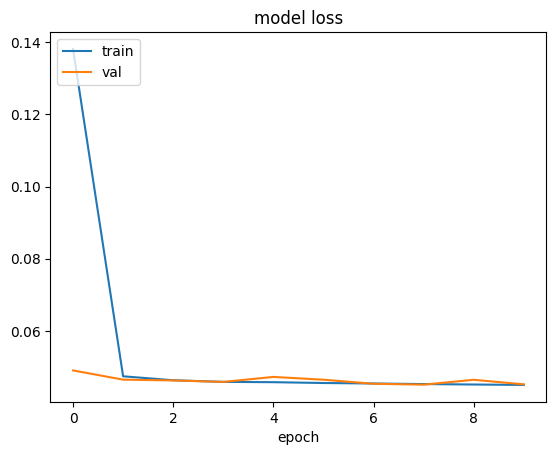

In [ ]:
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(r2_score(y_test, preds))

0.7748065104671696


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 8)                 264       
                                                                 
 dense_11 (Dense)            (None, 72)                648       
                                                                 
Total params: 912 (3.56 KB)
Trainable params: 912 (3.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
296/296 [==============================] - 6s 15ms/step - loss: 0.0523 - mean_absolute_error: 0.0523 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 2/5
296/296 [==============================] - 5s 16ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 3/5
296/296 [==============================] - 3s 11ms/step - loss: 0.0289 - mean_abs

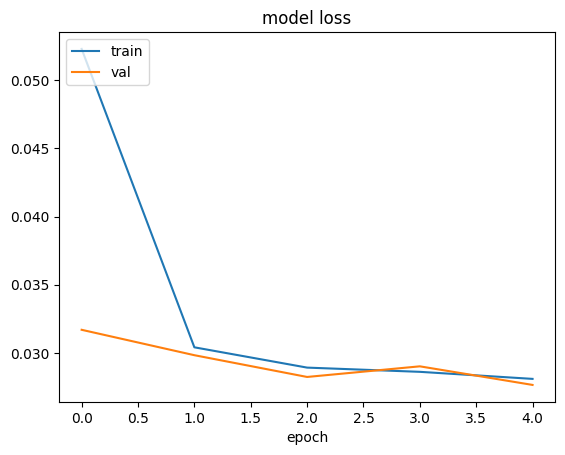

0.9160632624887705


In [ ]:
from tensorflow.keras.layers import GRU
random.seed(42)

simple_model = Sequential([
   GRU(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=5,
          batch_size=1024,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)

plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print(r2_score(preds, y_test))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 216, 10)           390       
                                                                 
 gru_17 (GRU)                (None, 216, 10)           660       
                                                                 
 gru_18 (GRU)                (None, 10)                660       
                                                                 
 dense_15 (Dense)            (None, 72)                792       
                                                                 
Total params: 2502 (9.77 KB)
Trainable params: 2502 (9.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
296/296 [==============================] - 16s 36ms/step - loss: 0.0606 - mean_absolute_error: 0.0606 - val_loss: 0.0452 - val_mean_absolute_e

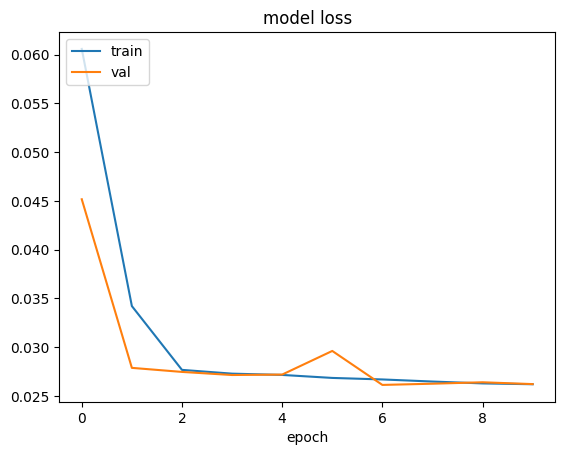

0.926687478752175


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
random.seed(42)

simple_model = Sequential([
   GRU(10, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True),
   GRU(10, activation='tanh', return_sequences=True),
   GRU(10, activation='tanh'),
   Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model
smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=10,  # Increased number of epochs
          batch_size=1024,  # Reduced batch size
          shuffle=True,
          callbacks=[early_stopping, reduce_lr]
)

# Predict and evaluate the model
preds = simple_model.predict(X_test_rs)

# Plot loss
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print(r2_score(preds, y_test))

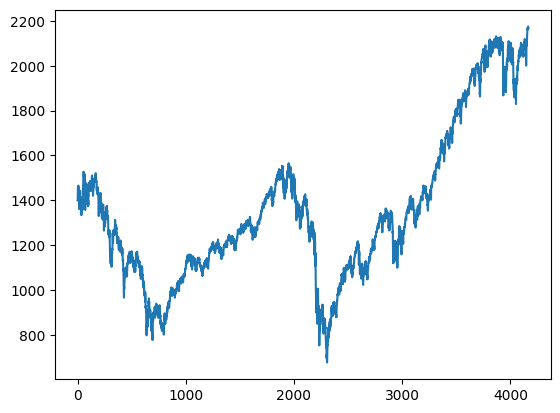

2791 1376
Epoch 1/200
223/223 - 6s - loss: 0.0244 - val_loss: 0.0045 - 6s/epoch - 27ms/step
Epoch 2/200
223/223 - 1s - loss: 0.0041 - val_loss: 9.5541e-04 - 1s/epoch - 5ms/step
Epoch 3/200
223/223 - 1s - loss: 0.0029 - val_loss: 6.3914e-04 - 1s/epoch - 5ms/step
Epoch 4/200
223/223 - 1s - loss: 0.0024 - val_loss: 5.8379e-04 - 1s/epoch - 5ms/step
Epoch 5/200
223/223 - 1s - loss: 0.0020 - val_loss: 5.5518e-04 - 1s/epoch - 5ms/step
Epoch 6/200
223/223 - 1s - loss: 0.0018 - val_loss: 5.6396e-04 - 1s/epoch - 5ms/step
Epoch 7/200
223/223 - 1s - loss: 0.0015 - val_loss: 4.8455e-04 - 1s/epoch - 5ms/step
Epoch 8/200
223/223 - 1s - loss: 0.0013 - val_loss: 3.2620e-04 - 1s/epoch - 5ms/step
Epoch 9/200
223/223 - 1s - loss: 0.0012 - val_loss: 3.1268e-04 - 1s/epoch - 5ms/step
Epoch 10/200
223/223 - 1s - loss: 9.6199e-04 - val_loss: 2.4664e-04 - 1s/epoch - 6ms/step
Epoch 11/200
223/223 - 2s - loss: 8.8157e-04 - val_loss: 3.0665e-04 - 2s/epoch - 7ms/step
Epoch 12/200
223/223 - 2s - loss: 8.4250e-04 - v

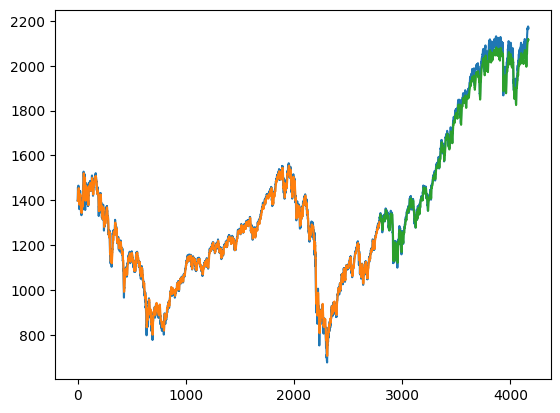

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load and visualize the data
dataset = pd.read_csv('/content/drive/MyDrive/sp500.csv', usecols=[0], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split the data into training and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Experiment with different look_back values
look_back = 3  # More context
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(20))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Use early stopping
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(trainX, trainY, epochs=200, batch_size=10, validation_split=0.2, verbose=2, callbacks=[early_stop])

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Plot baseline and predictions
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


# Part III

[A]

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from queue import PriorityQueue

In [ ]:
def a_star_search(start, target, nodes, neighbors, heuristics, edge_weights):
    frontier = PriorityQueue()
    frontier.put((0, start))
    came_from = {start: None}
    cost_so_far = {start: 0}

    while not frontier.empty():
        current_cost, current_node = frontier.get()

        if current_node == target:
            break
        print("Current Node:", current_node)
        leaf_nodes = {}
        for neighbor in neighbors[current_node]:
            weight = edge_weights[(current_node, neighbor)]
            new_cost = cost_so_far[current_node] + weight
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                priority = new_cost + heuristics[neighbor]
                frontier.put((priority, neighbor))
                came_from[neighbor] = current_node
                leaf_nodes[neighbor] = priority

        if not leaf_nodes:
            print("No leaf nodes found.")
            continue

        print("Leaf Nodes f(n):", leaf_nodes)
        selected_node = min(leaf_nodes, key=leaf_nodes.get)
        print("Selected Node:", selected_node)
        print("-----------------")

    return came_from

In [ ]:
def visualize_graph(nodes, neighbors, heuristics, edge_weights, target=None):
    G = nx.Graph()
    for node in nodes:
        for neighbor in neighbors[node]:
            weight = edge_weights[(node, neighbor)]
            G.add_edge(node, neighbor, weight=weight)

    pos = nx.spring_layout(G)

    edge_labels = {(node, neighbor): weight for (node, neighbor, weight) in G.edges(data='weight')}
    nx.draw(G, pos, with_labels=False, node_size=1500, node_color='green', font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    heuristic_labels = {node: f"{node}, h={heuristics[node]}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=heuristic_labels, font_color='white', font_size=8)

    if target:
        plt.title(f"Graph with Heuristics (Target: {target})")
    else:
        plt.title("Graph with Heuristics")
    plt.show()

In [ ]:
def print_result(start_node, target_node, nodes, neighbors, heuristics, edge_weights):
    print("Start Node:", start_node)
    print("Target Node:", target_node)
    print("-----------------")

    came_from = a_star_search(start_node, target_node, nodes, neighbors, heuristics, edge_weights)

    print("Shortest path:", end=" ")
    current_node = target_node
    while current_node != start_node:
        print(current_node, end=" <- ")
        current_node = came_from[current_node]
    print(start_node)

In [ ]:
nodes1 = ['S', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
neighbors1 = {
    'S': ['A', 'D'],
    'A': ['S', 'B', 'D'],
    'B': ['A', 'C', 'E'],
    'C': ['B'],
    'D': ['S', 'E', 'A'],
    'E': ['D', 'B', 'F'],
    'F': ['E', 'G'],
    'G': ['F']
}

heuristics1 = {
    'S': 11.5,
    'A': 10.1,
    'B': 5.8,
    'C': 3.4,
    'D': 9.2,
    'E': 7.1,
    'F': 3.5,
    'G': 0
}

edge_weights1 = {
    ('S', 'A'): 3,
    ('A', 'S'): 3,
    ('S', 'D'): 4,
    ('D', 'S'): 4,
    ('A', 'B'): 4,
    ('B', 'A'): 4,
    ('A', 'D'): 5,
    ('D', 'A'): 5,
    ('B', 'C'): 4,
    ('C', 'B'): 4,
    ('B', 'E'): 5,
    ('E', 'B'): 5,
    ('D', 'E'): 2,
    ('E', 'D'): 2,
    ('E', 'F'): 4,
    ('F', 'E'): 4,
    ('F', 'G'): 3.5,
    ('G', 'F'): 3.5
}

start_node1 = 'S'
target_node1 = 'G'

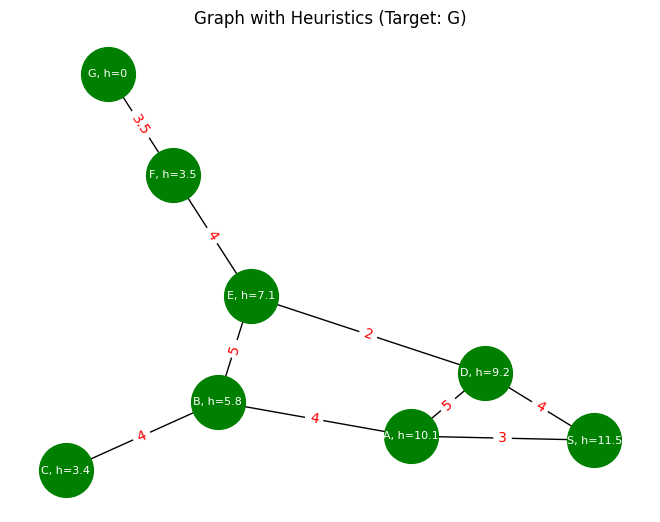

In [ ]:
visualize_graph(nodes1, neighbors1, heuristics1, edge_weights1, target=target_node1)

In [ ]:
print_result(start_node1, target_node1, nodes1, neighbors1, heuristics1, edge_weights1)

Start Node: S
Target Node: G
-----------------
Current Node: S
Leaf Nodes f(n): {'A': 13.1, 'D': 13.2}
Selected Node: A
-----------------
Current Node: A
Leaf Nodes f(n): {'B': 12.8}
Selected Node: B
-----------------
Current Node: B
Leaf Nodes f(n): {'C': 14.4, 'E': 19.1}
Selected Node: C
-----------------
Current Node: D
Leaf Nodes f(n): {'E': 13.1}
Selected Node: E
-----------------
Current Node: E
Leaf Nodes f(n): {'F': 13.5}
Selected Node: F
-----------------
Current Node: F
Leaf Nodes f(n): {'G': 13.5}
Selected Node: G
-----------------
Shortest path: G <- F <- E <- D <- S


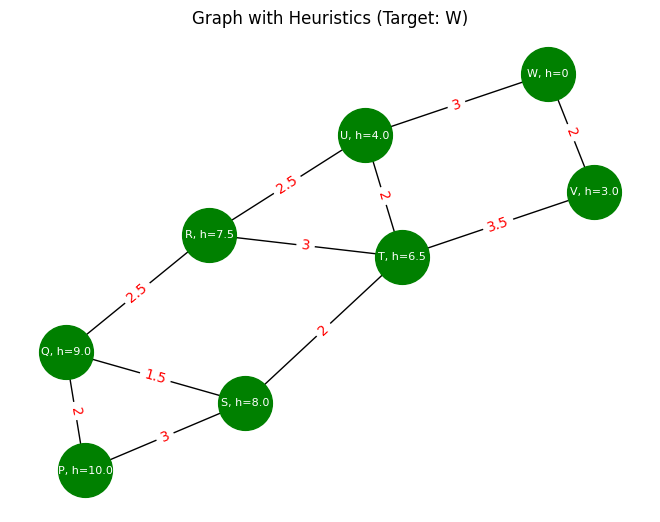

Start Node: P
Target Node: W
-----------------
Current Node: P
Leaf Nodes f(n): {'Q': 11.0, 'S': 11.0}
Selected Node: Q
-----------------
Current Node: Q
Leaf Nodes f(n): {'R': 12.0}
Selected Node: R
-----------------
Current Node: S
Leaf Nodes f(n): {'T': 11.5}
Selected Node: T
-----------------
Current Node: T
Leaf Nodes f(n): {'U': 11.0, 'V': 11.5}
Selected Node: U
-----------------
Current Node: U
Leaf Nodes f(n): {'W': 10}
Selected Node: W
-----------------
Shortest path: W <- U <- T <- S <- P


In [ ]:
nodes2 = ['P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W']
neighbors2 = {
    'P': ['Q', 'S'],
    'Q': ['P', 'R', 'S'],
    'R': ['Q', 'T', 'U'],
    'S': ['P', 'Q', 'T'],
    'T': ['S', 'R', 'U', 'V'],
    'U': ['R', 'T', 'W'],
    'V': ['T', 'W'],
    'W': ['U', 'V']
}

heuristics2 = {
    'P': 10.0,
    'Q': 9.0,
    'R': 7.5,
    'S': 8.0,
    'T': 6.5,
    'U': 4.0,
    'V': 3.0,
    'W': 0
}

edge_weights2 = {
    ('P', 'Q'): 2,
    ('Q', 'P'): 2,
    ('P', 'S'): 3,
    ('S', 'P'): 3,
    ('Q', 'R'): 2.5,
    ('R', 'Q'): 2.5,
    ('Q', 'S'): 1.5,
    ('S', 'Q'): 1.5,
    ('R', 'T'): 3,
    ('T', 'R'): 3,
    ('R', 'U'): 2.5,
    ('U', 'R'): 2.5,
    ('S', 'T'): 2,
    ('T', 'S'): 2,
    ('T', 'U'): 2,
    ('U', 'T'): 2,
    ('T', 'V'): 3.5,
    ('V', 'T'): 3.5,
    ('U', 'W'): 3,
    ('W', 'U'): 3,
    ('V', 'W'): 2,
    ('W', 'V'): 2
}

start_node2 = 'P'
target_node2 = 'W'

visualize_graph(nodes2, neighbors2, heuristics2, edge_weights2, target=target_node2)
print_result(start_node2, target_node2, nodes2, neighbors2, heuristics2, edge_weights2)


[B]

#### Tic Tac Toe

Define the player and opponent characters

In [ ]:
player, opponent = 'x', 'o'

This function checks if there are any moves left on the board

In [ ]:
def canMove(board):
    for i in range(3):
        for j in range(3):
            if board[i][j] == '_':
                return True
    return False

Evaluate the board state and returns a score based on whether the player or opponent has won or if it is a draw.

In [ ]:
def evaluate(b):
    # Checking for rows for X or O victory.
    for row in range(3):
        if b[row][0] == b[row][1] and b[row][1] == b[row][2]:
            if b[row][0] == player:
                return 10
            elif b[row][0] == opponent:
                return -10

    # Checking for columns
    for col in range(3):
        if b[0][col] == b[1][col] and b[1][col] == b[2][col]:
            if b[0][col] == player:
                return 10
            elif b[0][col] == opponent:
                return -10

    # Checking for diagonals
    if b[0][0] == b[1][1] and b[1][1] == b[2][2]:
        if b[0][0] == player:
            return 10
        elif b[0][0] == opponent:
            return -10

    if b[0][2] == b[1][1] and b[1][1] == b[2][0]:
        if b[0][2] == player:
            return 10
        elif b[0][2] == opponent:
            return -10

    return 0


Implement the minimax algorithm with a depth limit (maxDepth). It evaluates all possible moves and returns the best value based on whether it is the maximizer's or minimizer's turn.


In [ ]:
def minimax(board, depth, isMax, maxDepth):
    score = evaluate(board)

    # If Maximizer has won the game return his/her evaluated score
    if score == 10:
        return score

    # If Minimizer has won the game return his/her evaluated score
    if score == -10:
        return score

    # If there are no more moves and no winner then it is a tie
    if canMove(board) == False:
        return 0

    # If the maximum depth is reached, return the evaluation of the board
    if depth == maxDepth:
        return score

    # If this maximizer's move
    if isMax:
        best = -1000

        # Traverse all cells
        for i in range(3):
            for j in range(3):
                # Check if cell is empty
                if board[i][j] == '_':
                    # Make the move
                    board[i][j] = player

                    # Call minimax recursively and choose the maximum value
                    best = max(best, minimax(board, depth + 1, not isMax, maxDepth))

                    # Undo the move
                    board[i][j] = '_'
        return best

    # If this minimizer's move
    else:
        best = 1000

        # Traverse all cells
        for i in range(3):
            for j in range(3):
                # Check if cell is empty
                if board[i][j] == '_':
                    # Make the move
                    board[i][j] = opponent

                    # Call minimax recursively and choose the minimum value
                    best = min(best, minimax(board, depth + 1, not isMax, maxDepth))

                    # Undo the move
                    board[i][j] = '_'
        return best


Find the best possible move for the player by evaluating all empty cells using the minimax function. It updates the best move and best value as it traverses the board.

In [ ]:
# This function returns the best possible move for the player
def findBestMove(board, maxDepth):
    bestVal = -1000
    bestMove = (-1, -1)

    # Traverse all cells, evaluate minimax function for all empty cells. And return the cell with optimal value.
    for i in range(3):
        for j in range(3):
            # Check if cell is empty
            if board[i][j] == '_':
                # Make the move
                board[i][j] = player

                # Compute evaluation function for this move.
                moveVal = minimax(board, 0, False, maxDepth)

                # Undo the move
                board[i][j] = '_'

                # If the value of the current move is more than the best value, then update best
                if moveVal > bestVal:
                    bestMove = (i, j)
                    bestVal = moveVal

    print("The value of the best Move is:", bestVal)
    print()
    return bestMove


In [ ]:
board = [
    ['x', 'o', 'x'],
    ['o', 'o', 'x'],
    ['_', '_', '_']
]

# Example usage with depth limit
maxDepth = 2
bestMove = findBestMove(board, maxDepth)

print("The Optimal Move is:")
print("ROW:", bestMove[0], " COL:", bestMove[1])


The value of the best Move is: 10

The Optimal Move is:
ROW: 2  COL: 2


#### Nim

In [ ]:
player, opponent = 'Player', 'Opponent'

def canMove(heaps):
    return any(heap > 0 for heap in heaps)

def evaluate(heaps, isMax):
    if not canMove(heaps):
        return -1 if isMax else 1
    return 0

def minimax(heaps, depth, isMax, maxDepth):
    score = evaluate(heaps, isMax)

    if score != 0 or depth == maxDepth:
        return score

    if isMax:
        best = -float('inf')
        for i in range(len(heaps)):
            for k in range(1, heaps[i] + 1):
                newHeaps = heaps[:]
                newHeaps[i] -= k
                best = max(best, minimax(newHeaps, depth + 1, False, maxDepth))
        return best
    else:
        best = float('inf')
        for i in range(len(heaps)):
            for k in range(1, heaps[i] + 1):
                newHeaps = heaps[:]
                newHeaps[i] -= k
                best = min(best, minimax(newHeaps, depth + 1, True, maxDepth))
        return best

def findBestMove(heaps, maxDepth):
    bestVal = -float('inf')
    bestMove = (-1, -1)

    for i in range(len(heaps)):
        for k in range(1, heaps[i] + 1):
            newHeaps = heaps[:]
            newHeaps[i] -= k
            moveVal = minimax(newHeaps, 0, False, maxDepth)
            if moveVal > bestVal:
                bestMove = (i, k)
                bestVal = moveVal

    print("The value of the best Move is:", bestVal)
    return bestMove

# Define the initial state of the heaps
heaps = [1, 3]

# Define the maximum depth of the search
maxDepth = int(input("Enter the maximum depth for the Minimax search: "))

# Find the best move with the given depth limit
bestMove = findBestMove(heaps, maxDepth)

# Print the best move
print("The Optimal Move is to remove", bestMove[1], "from heap", bestMove[0])


Enter the maximum depth for the Minimax search: 2
The value of the best Move is: 1
The Optimal Move is to remove 2 from heap 1


[C]

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
from queue import PriorityQueue

In [ ]:
def dfs_traveral(graph, start):
    visited = set()
    visit_order = []

    def dfs_recursive(node):
        if node not in visited:
            visit_order.append(node)
            visited.add(node)
            for neighbor in graph[node]:
                dfs_recursive(neighbor)

    dfs_recursive(start)
    return visit_order


In [ ]:
def dfs_search(graph, start, goal):
    stack = [(start, [start])]
    while stack:
        (vertex, path) = stack.pop()
        for next in reversed(graph[vertex]):
            if next == goal:
                return path + [next]
            elif next not in path:
                stack.append((next, path + [next]))
    return None

In [ ]:
def draw_graph(graph):
    G = nx.Graph(graph)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=15)
    plt.show()

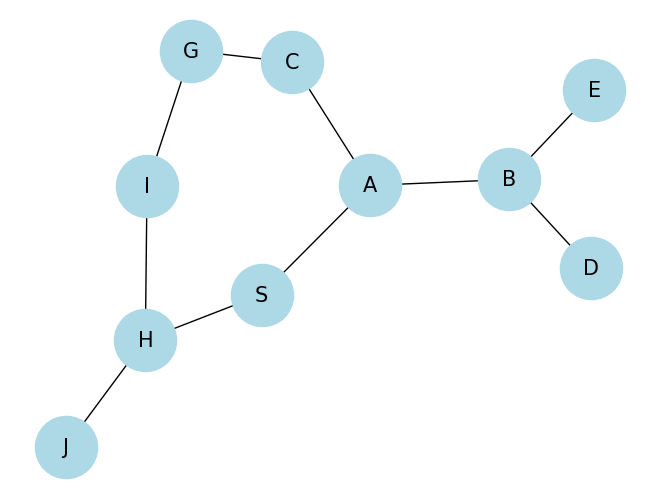

In [ ]:
graph = {
    'S': ['A', 'H'],
    'A': ['B', 'C'],
    'B': ['A','D', 'E'],
    'C': ['A','G'],
    'D': ['B'],
    'E': ['B'],
    'J': ['H'],
    'I': ['H','G'],
    'H': ['S', 'I', 'J'],
    'G': ['C','I']
}
draw_graph(graph)

In [ ]:
start_node = 'S'
end_node = 'G'
print("DFS traversal:", dfs_traveral(graph, start_node))
path = dfs_search(graph, start_node,end_node)
print("DFS Path:", path)

DFS traversal: ['S', 'A', 'B', 'D', 'E', 'C', 'G', 'I', 'H', 'J']
DFS Path: ['S', 'A', 'C', 'G']


In [ ]:
def bfs(graph, start, goal):
    queue = deque([(start, [start])])
    while queue:
        (vertex, path) = queue.popleft()
        for next in set(graph[vertex]) - set(path):
            if next == goal:
                return path + [next]
            else:
                queue.append((next, path + [next]))
    return None

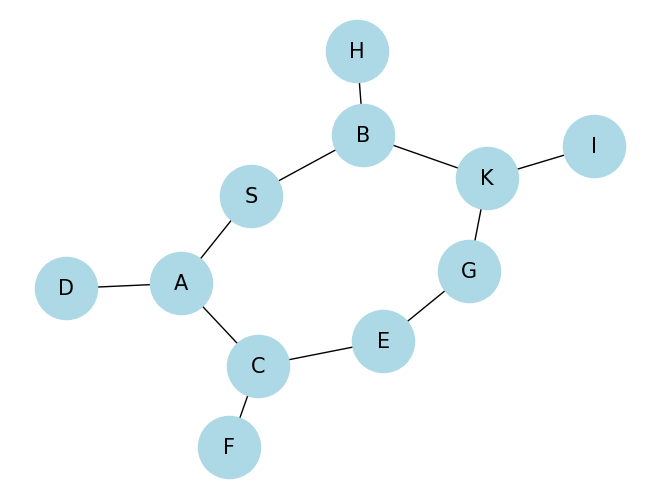

In [ ]:
graph = {
    'S': ['A', 'B'],
    'A': ['S', 'C', 'D'],
    'B': ['S', 'K', 'H'],
    'C': ['A', 'E', 'F'],
    'D': ['A'],
    'E': ['C', 'G'],
    'F': ['C'],
    'K': ['B', 'I','G'],
    'I': ['K'],
    'H': ['B'],
    'G': ['E','K']
}

draw_graph(graph)

In [ ]:
start_node = 'S'
end_node = 'G'
path = bfs(graph, start_node, end_node)
print("BFS Path:", path)

BFS Path: ['S', 'B', 'K', 'G']


In [ ]:
def ucs(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put((0, start, [start]))
    explored = set()

    while not frontier.empty():
        (cost, vertex, path) = frontier.get()
        if vertex in explored:
            continue
        explored.add(vertex)

        if vertex == goal:
            return path, cost

        for next, weight in graph[vertex]:
            if next not in explored:
                total_cost = cost + weight
                frontier.put((total_cost, next, path + [next]))
    return None

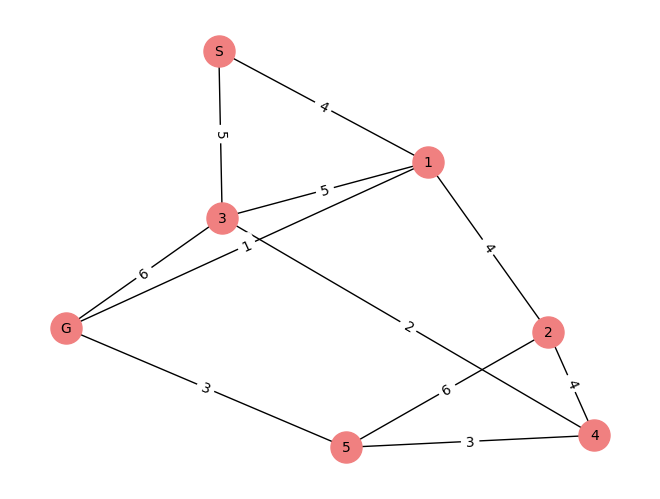

In [ ]:
graph = {
    '1': [('G', 1)],
    '2': [('1', 4)],
    '3': [('G', 6), ('1', 5),('4',2)],
    '4': [('2', 4), ('5', 3)],
    '5': [('2', 6), ('G', 3)],
    'S': [('1', 4), ('3', 5)]
}

G = nx.Graph()
for node, edges in graph.items():
    for edge in edges:
        G.add_edge(node, edge[0], weight=edge[1])
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_color='lightcoral', node_size=500, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [ ]:
start_node = 'S'
end_node = 'G'
path, total_cost = ucs(graph, start_node, end_node)
print("UCS Path with Weights:", path, "with total cost:", total_cost)

UCS Path with Weights: ['S', '1', 'G'] with total cost: 5


[D]

In [ ]:
!pip install simpleai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for simpleai: filename=simpleai-0.8.3-py3-none-any.whl size=100985 sha256=38da0f0d9636c5d27e32f964960b2e1c8131bc8033ab8eb6f744fec5240044dc
  Stored in directory: /root/.cache/pip/wheels/91/0c/38/421d7910e7bc59b97fc54f490808bdb1097607d83d1a592865
Successfully built simpleai


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from simpleai.search import CspProblem, backtrack

In [ ]:
def constraint_func(variables, values):
        return values[0] != values[1]

In [ ]:
def color_regions(n_colors, regions, neighbors):
    constraints = []
    for region, region_neighbors in neighbors.items():
        for neighbor in region_neighbors:
            constraints.append(([region, neighbor], constraint_func))

    problem = CspProblem(variables=regions, domains={region: list(range(1, n_colors + 1)) for region in regions}, constraints=constraints)
    result = backtrack(problem)
    return result

In [ ]:
def display_result(result):
    if result:
        G = nx.Graph()
        for region in regions:
            G.add_node(region, color=result[region])

        for region, region_neighbors in neighbors.items():
            for neighbor in region_neighbors:
                G.add_edge(region, neighbor)

        colors = [data['color'] for node, data in G.nodes(data=True)]
        nx.draw(G, with_labels=True, node_color=colors, cmap=plt.cm.rainbow, font_weight='bold')
        plt.show()
    else:
        print("No solution found.")

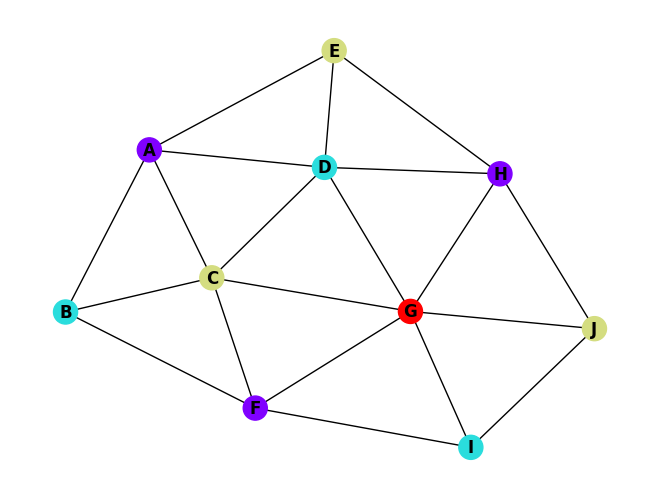

In [ ]:
regions = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
neighbors = {
    'A': ['B', 'C', 'D', 'E'],
    'B': ['A', 'C', 'F'],
    'C': ['A', 'B', 'D', 'F', 'G'],
    'D': ['A', 'C', 'E', 'G', 'H'],
    'E': ['A', 'D', 'H'],
    'F': ['B', 'C', 'G', 'I'],
    'G': ['C', 'D', 'F', 'H', 'I', 'J'],
    'H': ['D', 'E', 'G', 'J'],
    'I': ['F', 'G', 'J'],
    'J': ['G', 'H', 'I']
}

display_result(color_regions(4, regions, neighbors))